# Unsupervised Learning with Non-Ignorable Missing Data

Christine Hwang

In [1587]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline
import math

## Summary of Paper

### Overview
Missing data is defined to be non-ignorable if it is not missing at random. Non-ignorable missing data causes the inference based on observed data to lead to biased parameter estimates and can affect the significance of your results. This paper attempts to use probabilistic models to fill in missing data to reduce this bias

### Example
In the scenario where you have netflix movie ratings, you are more likely to rate movies that you really enjoy or really dislike, but rarely rate movies that you are neutral about. Therefore, most of the missing data tends to be from these middle ratings and the distribution of the observed data is shifted to the right from the true distribution of copmletely filled data. In this scenario, the probability of observing a particular response depends on the value itself. Therefore, ignoring missing data can lead to biased parameter estimates. 

### Standard Mixture Model

<img src="GraphicalModel.png">

This standard mixsture model shows a latent variable z behind each observation Y. In this example of a multinomial mixture model, $z_n$ represents the latent variable behind each entry which is pulled from a $\theta_k$ prior. This means that there are k different latent variables that our multinomial distribution can come from. For each observed value given its latent variable, there is a $\beta_{vmz}$ that represents the probability of any observation taking a specific value.

## Interpretation of the Model

Just want to make sure I have the right interpretation of the distribution.

Let us consider the scenario where we represent the netflix movie ratings as a multinomial distribution. Then from the diagram above, $Y_{1n'}$ = the rating star count for movie 1 for person n' and we assume there are n # people. Then if $Y_{im}$ = v, that means that the star count for movie i from person m = v. To represent each $Y_m$ is a multinomial distribution, we will define it as Mult($\theta_j$, M), where $\theta_z$ = P(selecting word v from latent variable z) where M is the total number of ratings.

$z_n$ ~ Mult($\pi$,1) 


$\pi$ = [.3, .2, .1, .4]

This means that the probability of having a latent variable $z_1$ = .3, $z_2$ = .2, etc.


If we represent each $Y_{m}|z_i$ ~ Multi($\theta_z$,N), we view $\theta_z$ to be the probability distribution of ratings for a single movie. For example, $\theta = [.1 .2 .7]$ means that the probability you give the movie 1 star is .1, probability you give it 2 stars is .2, and probability you give it three stars is .7, and you can set your M = N so that it follows a Multinomial($\theta$, N). This is because N people give movie $m$ a rating and therefore the distribution of all the ratings that the N people could have given movie $m$ is Multinoimal given the $\theta$.

Then the $\beta$ estimates $\theta$ is if we view $\theta$ to be the probability distribution of ratings for a single movie. For example, $\theta = [.1 .2 .7]$ means that the probability you give the movie 1 star is .1, probability you give it 2 stars is .2, and probability you give it three stars is .7, and you can set your M = N so that it follows a Multinomial($\theta$, N). Then it would make sense that $Y_{m}$~Multi($\beta$,N) which represents the ratings from N people for the $m^{th}$ movie.

### CPT-v Model

<img src="Model2.png">

We extrapolate from the previous model to show the missing data. $\mu_v$ = $P(R_m = 1 | Y_m = v)$, whic his the probability the value is missing given the true value of the data. In our movie rating example, this probability is higher is $Y_m = 2-3$ because we are less likely to see a rating for a mediocre movie. Need to clarify previous questions before analyzing this model further.

## Medical Application

I hope to apply this model of missing data to medical data. For example, in data analyzing blood pressure or cholesterol, we may see that the probability of seeing missing values for younger, healthier people is higher than for older people because they are less likely to have health complications that require these measurements. Doctors may assume that these measurements are not necessary for the checkup and therefore the data will not be missing at random. In order to use this probabilistic model to fill in missing values, I need to understanding how these categorical variables (if you just convert them to integers) can represent a multinomial distribution. If a person's blood pressure can take the values [10, 50, 100], and our $\theta = [.2 .2 .6]$, does this mean that the person's blood pressure = Multinomial($\theta$, 1)? 

## Baseline Implementation

<img src="EM.png">

$\phi_{zn}$ = posterior distribution of the latent variable z 

$\theta_z$ = probability of that latent variable Z = z

$\beta_{vmz}$ = probability that Y = v given latent variable

$\mu_v$ = probability that $Y_i$ is missing given is has value v.

$\gamma$ and $\lambda$ are intermediate variables without interpretable value.

$\delta = I(y_{mn} = v)$


## Priors

$u_v$ comes from a beta distribution because it is a prior for a Binomial Distribution

$\theta$ comes from a Dirichlet distribution

$\beta$ comes from a dirichlet distribution

### Generate Full Data
I created the probability distribution of movies for there different movies. Movie 1 is a bad movie that is likely to get a lot of 1s. Beta 2 is just an average movie whose ratings will resemble a normal distribution centered at 3. Movie 3 is a great movie that is likely to get very high reviews. Concatentate these ratings to get your full data set of 100 movie ratings for these 3 movies.

## Question:
I don't think I'm coding this correctly so that the reviews are consistent with each person.. Walk through approach and ask if it makes intuitive sense

In [1650]:
def simulate_data(z=1, n = 100, m = 3, v = 5):
    
    ### create the different betas
    #########
    # If there are three latent variables, then each movie will have 3 sets of probability distributions
    # because there can be "teen, young adult, old people" categories that have different movie preferences.
    #
    # Input: z = 3, m = 3
    # Output: [ (z1:m1 rating),(z1:m2 rating), (z1:m3 rating), (z2:m1 rating), etc]
    #
    #########
    all_beta = []
    for z_ in range(z):
        beta = []
        for m_ in range(m):
            beta_temp = np.random.dirichlet(np.ones(v),size=1)[0]
            beta.append(beta_temp)
        all_beta.append(beta)
        
#     theta = np.random.dirichlet(np.ones(z),size = 1)[0]
    # Generates which latent variable each user comes from    
    z_list = np.random.randint(1,z+1,n)
    complete_data = np.zeros((n,m))
    for i in range(len(z_list)):
        for m_ in range(m):
            complete_data[i][m_] = np.argmax(np.random.multinomial(1,list(all_beta[z_list[i]-1][m_])))+1
    return complete_data, all_beta,z_list

In [1609]:
# z=3
# m = 5
# v = 5
# n = 1000
# complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)

### Mu Initialization

In the paper in study, we let $\mu_v(s)$ = $s$($v$ − 3) + 0.5, where $s$ is the parameter that controls the strength of the effect. I will set $s$ = .075. 

In terms of the example of a movie rating, It makes more sense that the movie will be missing reviews it is a neutral movie than a bad movie. Therefore, I reversed the probability so that it more resembles a bell shaped distribution where the probability of the rating being missing peaks when star = 3.

In [1610]:
# for i in range(v):
#     mu[i] = -.075*abs(i-2)+.5
# mu

### Pattern for Missing Data (R)

Given this, we want to create a matrix that indicates 1 if the data is observed and 0 otherwise.

### Pull $\theta, \beta$ from Dirichlet

Because $\theta$ and $\beta$ are good priors for categorical distribution and multinomial distributions, they are appropriate priors for $\theta$ and $\beta$ because both represent the probability of taking a specific categorical value.

In [1651]:
#### proxy for when it found convergence rather than iterating but very volatile results that don't really converge
#### if i set epsilon to be smaller?

def run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data,r):
    import time

    start = time.time()
    
    ### store the past
    past_beta = np.zeros((v,m,z))
    past_gamma = np.zeros((m,z,n))
    past_phi = np.zeros((z,n))
    past_mu = np.zeros(v)
    past_lambda_ = np.zeros((v,m,z,n))
    past_theta = np.zeros(z)
    
    counter= 0
    
    eps = .01
#     while(abs(past_beta-beta).sum() > eps and abs(past_gamma-gamma).sum() > eps and abs(past_mu-mu).sum() > eps and
#          abs(past_phi-phi).sum() > eps and abs(past_lambda_-lambda_).sum() > eps and abs(past_theta-theta).sum() > eps): 
    for i in range(100):    

        ### E step
        past_phi = np.copy(phi)
        past_lambda_ = np.copy(lambda_)
        past_theta = np.copy(theta)
        past_beta = np.copy(beta)
        past_gamma = np.copy(gamma)
        past_mu = np.copy(mu)
        ###### lambda
        for v_ in range(v):
            for m_ in range(m):
                for z_ in range(z):
                    for n_ in range(n):
                        lambda_[v_][m_][z_][n_] = ((complete_data[n_][m_]==(v_+1))*mu[v_]*beta[v_][m_][z_])**r[n_][m_]*((1-mu[v_])*beta[v_][m_][z_])**(1-r[n_][m_])


        ###### gamma
        gamma = lambda_.sum(axis = 0)

        ##### vectorized phi
        phi = np.tile(theta, (n,1)).T*gamma.prod(axis = 0)/(np.tile(theta, (n,1)).T*gamma.prod(axis = 0)).sum(axis=0)


        ### M step
        theta = phi.sum(axis=1)/phi.sum()

        #vectorized beta
        for v_ in range(v):
            for m_ in range(m):
                for z_ in range(z):
                    sum_ = 0
                    for n_ in range(n):
                        sum_ += phi[z_][n_]*lambda_[v_][m_][z_][n_]/gamma[m_][z_][n_]
                    beta[v_][m_][z_] = sum_

        beta = beta/phi.sum(axis=1)


        ######mu
        for v_ in range(v):
            num = 0
            denom = 0
            for n_ in range(n):
                for z_ in range(z):
                    for m_ in range(m):
                        num += phi[z_][n_]*r[n_][m_]*lambda_[v_][m_][z_][n_]/gamma[m_][z_][n_]
                        denom += phi[z_][n_]*lambda_[v_][m_][z_][n_]/gamma[m_][z_][n_]
            mu[v_] = num/denom

        if counter % 100 == 0:
            print counter
        counter += 1
    end = time.time()
    print(end - start)  
    return mu,gamma,phi,beta,theta,lambda_

In [1652]:
def create_prior(v,m,z,n):
    #mu
    mu = np.ones(v)
    for i in range(v):
        mu[i] = -.075*abs(i-2)+.5
    if z == 1:
        theta = [1]
    else:
        c = ()
        for i in range(z):
            c = (1,)+c
            
        theta = np.random.dirichlet(c,1).reshape((z,))
    c = ()
    for m_ in range(v):
        c = (1,) + c
    beta = np.random.dirichlet(c,(z,m)).transpose()
    
    phi = np.random.random((z,n))
    gamma = np.random.random((m,z,n))
    lambda_ = np.random.random((v,m,z,n))
    
    return mu,theta,beta,phi,gamma,lambda_


In [1653]:
def calculate_missing(n,m,complete_data,mu):
    ####### R matrix that decides which values are missing
    r = np.ones((n,m))
    for n_ in range(n):
        for m_ in range(m):
            val = complete_data[n_][m_]
            if np.random.rand(1) < mu[val-1]:
                r[n_][m_] = 0
    return r
                

In [1654]:
def missing_value_filled_in(mu,phi,beta,n,m,missing_data,sample,replace = 0):
    
    ### fills in the data
    for n_ in range(n):
        for m_ in range(m):
            latent = np.argmax(phi[:,n_])
            if missing_data[n_][m_] == replace:
                temp = []
                for i in range(sample):
                    temp.append(np.argmax(np.random.multinomial(1, beta[:,m_,latent]))+1)
                missing_data[n_][m_] = np.mean(temp)
       
    return missing_data

In [1661]:
z=1
m = 5
v = 5
n = 1000
complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)

In [1662]:
mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)

In [1663]:
r = calculate_missing(n,m,complete_data,mu)

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [1678]:
target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))

In [1668]:
mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data*r,r)

0
36.4200768471


In [1669]:
missing_data = r*complete_data
missing_data

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 5.,  4.,  0.,  0.,  2.],
       [ 1.,  4.,  0.,  4.,  5.],
       ..., 
       [ 1.,  0.,  5.,  0.,  0.],
       [ 5.,  4.,  1.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [1679]:
n_sample = [1,5,10,15,20,30,40]
score = []
for n_ in n_sample:
    model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),n_)
    
    lasso = Lasso_Reg(alpha = 0)
    lasso.fit(np.array(model_filled_in),target_var)
    score.append(lasso.score(np.array(model_filled_in),target_var))

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [1680]:
score

[0.34882027559103845,
 0.50117252853545358,
 0.52796287753056048,
 0.53213095205379801,
 0.54301554105336702,
 0.54361394217460668,
 0.54262173250854739]

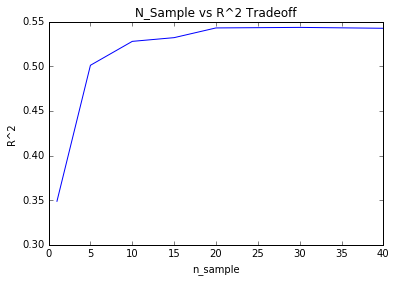

In [1691]:
plt.plot(n_sample,score)
plt.ylabel('R^2')
plt.xlabel('n_sample')
plt.title('N_Sample vs R^2 Tradeoff')

In [1681]:
def standard_imputation(missing_data):
    column_names = missing_data.columns
    for col in column_names:
        col_mean = np.mean(missing_data[col])
        for i in range(len(missing_data[col])):
            if missing_data[col][i] == 0:
                missing_data[col][i] = col_mean
    print missing_data.shape
    return missing_data

In [1682]:
standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))


(1000, 5)


In [1683]:
lasso = Lasso_Reg(alpha = 0)
lasso.fit(np.array(model_filled_in),target_var)
print lasso.score(np.array(model_filled_in),target_var)

0.542621732509


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app


In [1684]:
lasso = Lasso_Reg(alpha = 0)
lasso.fit(np.array(standard_missing_data),target_var)
print lasso.score(np.array(standard_missing_data),target_var)

0.445373732626


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app


In [1685]:
lasso = Lasso_Reg(alpha = 0)
lasso.fit(np.array(complete_data),target_var)
print lasso.score(np.array(complete_data),target_var)

0.914360810516


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app


### Time Markdown
With the previous brute force method for phi, the time it took to run 10,000 iterations was 277.


With the vectorized method for phi, the time it took to run 10,000 iterations was 256.


After vectorizing the denominator of beta, it sped up to 235.

Using the convergence proxy, I clearly don't need 10,000 iterations so maybe vectorizing not entirelly necessary

# Multiple latent variable progress

In [1693]:
z_range = range(1,10)
rep = range(1,5)
latent_score = []
for z_ in z_range:
    for i in rep:
        z=z_
        m = 5
        v = 5
        n = 5000
        complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)
        mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)
        r = calculate_missing(n,m,complete_data,mu)
        mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data,r)
        missing_data = r*complete_data
        model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10)
        target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))

        
        standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))
        
        lasso = Lasso_Reg(alpha = 0)
        lasso.fit(np.array(standard_missing_data),target_var)
        standard_score =  lasso.score(np.array(standard_missing_data),target_var)
        
        lasso = Lasso_Reg(alpha = 0)
        lasso.fit(np.array(model_filled_in),target_var)
        model_score =  lasso.score(np.array(model_filled_in),target_var)
        
        
        latent_score.append(model_score-standard_score)

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
178.746155024
(5000, 5)


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


0
5471.58305383
(5000, 5)
0


KeyboardInterrupt: 

In [ ]:
model_filled_in

In [239]:
print "my model,", lasso.score(np.array(model_filled_in),target_var)
lasso = Lasso_Reg(alpha = 0)
lasso.fit(np.array(standard_missing_data),target_var)
print "impute with mean", lasso.score(np.array(standard_missing_data),target_var)
lasso = Lasso_Reg(alpha = 0)
lasso.fit(np.array(complete_data),target_var)
print "complete data model",lasso.score(np.array(complete_data),target_var)

my model, 0.519206335835
impute with mean 0.386073104787


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


complete data model 0.883765549852


# Using prediction for actual real DataSet (mammographic data UCI)

# Testing for levels of missing ness

In [1416]:
def fill_missing_data(missing_data,z=1):
    z=z
    m = 1
    v = int(missing_data.max())
    n = len(missing_data)
    
    missing_data = missing_data.reshape((n,m))
    mu_prior,theta_prior,beta_prior,phi_prior,gamma_prior,lambda_prior = create_prior(v,m,z,n)
    r = np.array([ 1-(x== -9) for x in missing_data]).reshape((n,m))
    mu,gamma,phi,beta,theta,lambda_ = run_EM(theta_prior,beta_prior,phi_prior,gamma_prior,mu_prior,lambda_prior,v,m,z,n,missing_data,r)
    model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10,replace=-9)
    return model_filled_in

In [1363]:
import urllib
raw_data = urllib.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data")

In [1364]:
dataset = np.loadtxt(raw_data,dtype = np.str_, delimiter=",")

In [1365]:
dataset = pd.DataFrame(dataset)

In [1366]:
dataset = dataset.replace('?','-9')
dataset = dataset.astype(float)

In [1367]:
dataset_missing_2 = dataset[dataset[2]==-9]
dataset_missing_3 = dataset[dataset[3]==-9]
dataset_missing_4 = dataset[dataset[4]==-9]
df_missing = pd.concat([dataset_missing_2,dataset_missing_3,dataset_missing_4],axis=0)
len(df_missing)

155

In [1368]:
dataset_full_2 = dataset[dataset[2]!=-9]
dataset_full_3 = dataset[dataset[3]!=-9]
dataset_full_4 = dataset[dataset[4]!=-9]
df_full = pd.concat([dataset_full_2,dataset_full_3,dataset_full_4])
df_full = df_full.sample(n=400)
len(df_full)
df = pd.concat([df_full, df_missing],axis=0)
df = df.drop_duplicates()

In [1369]:
model_2 = fill_missing_data(df[2], z = 1)
model_3 = fill_missing_data(df[3], z = 1)
model_4 = fill_missing_data(df[4], z = 1)
# model_5 = fill_missing_data(dataset[5])

0
2.46968793869
0
2.84946393967
0
2.12961101532


In [1370]:
dataset_fancy = np.copy(df)
dataset_fancy[:,2] = model_2.reshape((len(model_2),))
dataset_fancy[:,3] = model_3.reshape((len(model_3),))
dataset_fancy[:,4] =  model_4.reshape((len(model_4),))

In [1371]:
dataset_fancy  = pd.DataFrame(dataset_fancy)

In [1372]:
train_indices = np.random.uniform(size=len(dataset_fancy[0])) > 1. / 3.

In [1373]:
train = pd.DataFrame(df[train_indices])
test = pd.DataFrame(df[~train_indices])

In [1374]:
col2_mean = np.mean(train[2][train[2]>-9])
col3_mean = np.mean(train[3][train[3]>-9])
col4_mean = np.mean(train[4][train[4]>-9])

In [1375]:
train[2] = train[2].replace(-9,col2_mean)
train[3] = train[3].replace(-9,col3_mean)
train[4] = train[4].replace(-9,col4_mean)


In [1376]:
col2_mean = np.mean(test[2][test[2]>-9])
col3_mean = np.mean(test[3][test[3]>-9])
col4_mean = np.mean(test[4][test[4]>-9])
test[2] = test[2].replace(-9,col2_mean)
test[3] = test[3].replace(-9,col3_mean)
test[4] = test[4].replace(-9,col4_mean)


In [1377]:
standard = LogisticRegression()
standard.fit(train[[0,1,2,3,4]],train[5])
standard.score(test[[0,1,2,3,4]],test[5])

0.82307692307692304

In [1378]:
train = dataset_fancy[train_indices]
test = dataset_fancy[~train_indices]

In [1379]:
model = LogisticRegression()
model.fit(train[[ 0,1,2,3,4]],train[5])
model.score(test[[0,1,2,3,4]],test[5])

0.80000000000000004

# Add Noise

In [1551]:
import urllib
raw_data = urllib.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data")

In [1552]:
dataset = np.loadtxt(raw_data,dtype = np.str_, delimiter=",")
dataset = pd.DataFrame(dataset)

In [1553]:
dataset = dataset.replace('?','-9')
dataset = dataset.astype(float)

In [1519]:
# noise = np.random.randint(low = 0, high = 2,size = (961,6))
# r = np.random.randint(low = 0, high = 1, size=((961,6)))
# dataset_noisy = noise*r+dataset

In [1709]:
np.random.randint(0,2)

1

In [1527]:
model_2 = fill_missing_data(dataset[2], z = 7)
model_3 = fill_missing_data(dataset[3], z = 7)
model_4 = fill_missing_data(dataset[4], z = 7)
# model_5 = fill_missing_data(dataset[5])

0
41.4691050053
0
52.1566331387
0
37.5152111053


In [1528]:
dataset_fancy = np.copy(dataset)
dataset_fancy[:,2] = model_2.reshape((len(model_2),))
dataset_fancy[:,3] = model_3.reshape((len(model_3),))
dataset_fancy[:,4] =  model_4.reshape((len(model_4),))
dataset_fancy  = pd.DataFrame(dataset_fancy)

In [1529]:
train_indices = np.random.uniform(size=len(dataset_fancy[0])) > 1. / 3.
train = pd.DataFrame(dataset_noisy[train_indices])
test = pd.DataFrame(dataset_noisy[~train_indices])

In [1530]:

col2_mean = np.mean(train[2][train[2]>=0])
col3_mean = np.mean(train[3][train[3]>=0])
col4_mean = np.mean(train[4][train[4]>=0])
train[2] = train[2].replace(-9,col2_mean)
train[3] = train[3].replace(-9,col3_mean)
train[4] = train[4].replace(-9,col4_mean)


col2_mean = np.mean(test[2][test[2]>=0])
col3_mean = np.mean(test[3][test[3]>=0])
col4_mean = np.mean(test[4][test[4]>=0])
test[2] = test[2].replace(-9,col2_mean)
test[3] = test[3].replace(-9,col3_mean)
test[4] = test[4].replace(-9,col4_mean)


In [1531]:
standard = LogisticRegression()
standard.fit(train[[0,1,2,3,4]],train[5])
standard.score(test[[0,1,2,3,4]],test[5])

0.79940119760479045

In [1532]:
train = dataset_fancy[train_indices]
test = dataset_fancy[~train_indices]

In [1533]:
model = LogisticRegression()
model.fit(train[[ 0,1,2,3,4]],train[5])
model.score(test[[0,1,2,3,4]],test[5])

0.79041916167664672

# Tune the Latent Variable

In [1561]:
import urllib
raw_data = urllib.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data")
dataset = np.loadtxt(raw_data,dtype = np.str_, delimiter=",")
dataset = pd.DataFrame(dataset)
dataset = dataset.replace('?','-9')
dataset = dataset.astype(float)

In [1696]:
from sklearn.cross_validation import KFold
best_score = 0
overall_score = []
for z_ in range(1,9):
    # Cross validation for every experiment
    k_folds = KFold(len(dataset[0]), n_folds=5, shuffle=True)
    scores = []
    
    for train_indices, validation_indices in k_folds:
        model_2 = fill_missing_data(dataset[2], z = z_)
        model_3 = fill_missing_data(dataset[3], z = z_)
        model_4 = fill_missing_data(dataset[4], z = z_)

        dataset_fancy = np.copy(dataset)
        dataset_fancy[:,2] = model_2.reshape((len(model_2),))
        dataset_fancy[:,3] = model_3.reshape((len(model_3),))
        dataset_fancy[:,4] =  model_4.reshape((len(model_4),))
        dataset_fancy  = pd.DataFrame(dataset_fancy)
        
        
        
#         # Generate training data
#         train_cv = dataset[train_indices]
        
#         # Generate validation data
#         validate = dataset[validation_indices]
        

#         col2_mean = np.mean(train_cv[2][train_cv[2]>=0])
#         col3_mean = np.mean(train_cv[3][train_cv[3]>=0])
#         col4_mean = np.mean(train_cv[4][train_cv[4]>=0])
#         train_cv[2] = train_cv[2].replace(-9,col2_mean)
#         train_cv[3] = train_cv[3].replace(-9,col3_mean)
#         train_cv[4] = train_cv[4].replace(-9,col4_mean)


#         col2_mean = np.mean(validate[2][validate[2]>=0])
#         col3_mean = np.mean(validate[3][validate[3]>=0])
#         col4_mean = np.mean(validate[4][validate[4]>=0])
#         validate[2] = validate[2].replace(-9,col2_mean)
#         validate[3] = validate[3].replace(-9,col3_mean)
#         validate[4] = validate[4].replace(-9,col4_mean)

        
        
        
        # Fit random forest on training data
#         standard = LogisticRegression()
#         standard.fit(train_cv[[0,1,2,3,4]],train_cv[5])
#         diff += model.score(validate[[0,1,2,3,4]],validate[5]) - standard.score(validate[[0,1,2,3,4]],validate[5])
    
    
        # Generate training data
        train_cv = np.array(dataset_fancy)[train_indices]
        train_cv = pd.DataFrame(train_cv)
        # Generate validation data
        validate = np.array(dataset_fancy)[validation_indices]
        validate = pd.DataFrame(validate)
        
        model = LogisticRegression()
        model.fit(train_cv[[ 0,1,2,3,4]],train_cv[5])
        scores.append(model.score(validate[[0,1,2,3,4]],validate[5]))
        
        
    # Record and report accuracy
    average_score = np.mean(scores)
    overall_score.append(average_score)
#     average_diff = np.mean(diff)
    # Update our record of the best parameters see so far
    if average_score > best_score:
        best_score = average_score
        best_z = z_
        
#     if average_diff > best_diff:
#         best_diff = average_diff
#         best_z_diff = z_



0
5.83701586723
0
7.63048219681
0
7.82010817528
0
6.1628510952
0
12.1082279682
0
14.0896232128
0
8.44600391388
0
13.4143419266
0
6.00969696045
0
6.14981102943
0
6.91462302208
0
5.32743906975
0
5.39202809334
0
7.10862088203
0
7.30707502365
0
17.6918418407
0
13.457116127
0
11.8031179905
0
10.8745141029
0
15.4700989723
0
11.2282640934
0
11.5617349148
0
16.301705122
0
12.999876976
0
11.0371890068
0
16.9260518551
0
11.788433075
0
11.431551218
0
13.9045629501
0
11.9944159985
0
16.3791439533
0
20.6016118526
0
16.8025410175
0
16.6302511692
0
21.8169391155
0
17.4754750729
0
18.0213589668
0
19.4798059464
0
19.6076490879
0
17.8675198555
0
25.5449249744
0
16.1344070435
0
22.5231420994
0
27.7434790134
0
18.0531020164
0
25.8285629749
0
32.3183629513
0
25.2814941406
0
24.16741395
0
31.7563738823
0
24.6792690754
0
23.9348831177
0
31.7950329781
0
23.6694350243
0
24.0542039871
0
30.7557580471
0
23.6576840878
0
24.0259540081
0
31.6595900059
0
24.9731309414
0
31.0116109848
0
43.1971859932
0
36.6573169231


In [1701]:
best_z

4

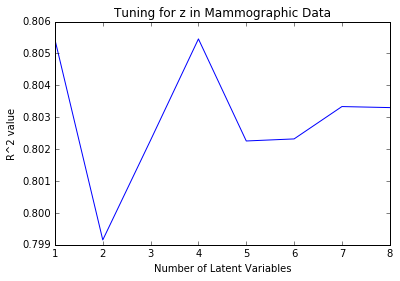

In [1703]:
plt.plot(range(1,9),overall_score)
plt.xlabel('Number of Latent Variables')
plt.ylabel("R^2 value")
plt.title("Tuning for z in Mammographic Data")

In [1573]:
import urllib
raw_data = urllib.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data")
dataset = np.loadtxt(raw_data,dtype = np.str_, delimiter=",")
dataset = pd.DataFrame(dataset)
dataset = dataset.replace('?','-9')
dataset = dataset.astype(float)

In [1574]:
model_2 = fill_missing_data(dataset[2], z = 4)
model_3 = fill_missing_data(dataset[3], z = 4)
model_4 = fill_missing_data(dataset[4], z = 4)
# model_5 = fill_missing_data(dataset[5])
dataset_fancy = np.copy(dataset)
dataset_fancy[:,2] = model_2.reshape((len(model_2),))
dataset_fancy[:,3] = model_3.reshape((len(model_3),))
dataset_fancy[:,4] =  model_4.reshape((len(model_4),))
dataset_fancy  = pd.DataFrame(dataset_fancy)

0
21.0729119778
0
26.9510920048
0
22.162058115


In [1583]:
train_indices = np.random.uniform(size=len(dataset_fancy[0])) > 1. / 3.
train = pd.DataFrame(dataset_noisy[train_indices])
test = pd.DataFrame(dataset_noisy[~train_indices])

In [1584]:
col2_mean = np.mean(train[2][train[2]>=0])
col3_mean = np.mean(train[3][train[3]>=0])
col4_mean = np.mean(train[4][train[4]>=0])
train[2] = train[2].replace(-9,col2_mean)
train[3] = train[3].replace(-9,col3_mean)
train[4] = train[4].replace(-9,col4_mean)


col2_mean = np.mean(test[2][test[2]>=0])
col3_mean = np.mean(test[3][test[3]>=0])
col4_mean = np.mean(test[4][test[4]>=0])
test[2] = test[2].replace(-9,col2_mean)
test[3] = test[3].replace(-9,col3_mean)
test[4] = test[4].replace(-9,col4_mean)

In [1585]:
standard = LogisticRegression()
standard.fit(train[[0,1,2,3,4]],train[5])
standard.score(test[[0,1,2,3,4]],test[5])

0.8271604938271605

In [1586]:
train = dataset_fancy[train_indices]
test = dataset_fancy[~train_indices]
model = LogisticRegression()
model.fit(train[[ 0,1,2,3,4]],train[5])
model.score(test[[0,1,2,3,4]],test[5])

0.83024691358024694

### Analysis

Wow! My code actually works. Our original beta estimates were $[[.5,.2,.1,.1,.1],[.1,.2,.5,.2,.1],[.05,.1,.1,.35,.4]]$. We can see from the $\beta$ estimates that for the first movie, you are more likely to give it a 1 and for the last movie, you are more likely to give it a 5 and for the second movie, you are most likely to give it a 3. That's what our initial beta estimates are!!

# Predictions

The concept behind predicting is that now that we have a converged beta, for each of the missing values, we will pull the rating value $v$ from a multinomial distribution. How do I deal with this when there are latent variables? How do you know which latent variable each perosn is from? I can take the posterior distribution of the phi and take the argmax to identify which latent variable he or she comes from. 

In [102]:
fill_in_data = r*complete_data
for n_ in range(n):
    for m_ in range(m):
        latent = np.argmax(phi[:,n_])
        if fill_in_data[n_][m_] == 0:
            fill_in_data[n_][m_] = np.argmax(np.random.multinomial(1, beta[:,m_,latent]))+1

In [103]:
r[11]

array([ 1.,  1.,  1.])

In [104]:
fill_in_data[11]

array([ 1.,  2.,  2.])

In [105]:
complete_data[11]

array([1, 2, 2])

In [106]:
def fill_in_accuracy(complete,filled,rmse = True):
    if not rmse:
        difference = 0
        total = 0
        for n_ in range(n):
            for m_ in range(m):
                if (complete[n_][m_] + filled[n_][m_] <> 0):
                    total += 1
                    if complete[n_][m_] == filled[n_][m_]:
                        difference += 1
        print "The total number of missing values is", total
        print "The number of accurate filled values is", difference
    else:
        mad = abs(complete_data[np.nonzero((1-r)*complete_data)]-fill_in_data[np.nonzero((1-r)*fill_in_data)]).mean()
        print "the mean absolute deviation is",mad

In [107]:
fill_in_accuracy((1-r)*complete_data,(1-r)*fill_in_data, rmse=False)
fill_in_accuracy((1-r)*complete_data,(1-r)*fill_in_data, rmse=True)

The total number of missing values is 117
The number of accurate filled values is 35
the mean absolute deviation is 1.2905982906


### Future Steps

I had to hard code with for loop for three of the predictors. Working on how to use matrix multiplication but can't see a clear pattern. Also not sure how to use $\beta$ to actually predict the values after the fitting is done. Do I call np.random.multinomial($\beta$, 1) then take the index of the array that has 1 success and fill in that missing value?

## Next Steps
-- after talk with Weiwei on Tuesday, 

    -- create a function handle multiple latent variables. x
    
    -- speed up by vectorizing some of the code x
    
    -- run the loop using epsilon rather than just a lot of loops. 

## Links

Description of Multinomial Mixture Models
http://web.stanford.edu/~lmackey/stats306b/doc/stats306b-spring14-lecture3_scribed.pdf
https://www.cs.princeton.edu/courses/archive/spring12/cos424/pdf/em-mixtures.pdf

My specific Paper
http://www.cs.ubc.ca/~bmarlin/research/presentations/lnimd_group_talk.pdf
https://people.cs.umass.edu/~marlin/research/papers/aistat-lnimd.pdf

Application of my paper
http://ijcai.org/Proceedings/11/Papers/447.pdf
http://www.cs.toronto.edu/~zemel/documents/cfmar-uai2007.pdf
https://pdfs.semanticscholar.org/2845/eda7ce8de14e351d41182f92b73ece8873ef.pdf
https://people.cs.umass.edu/~marlin/research/thesis/cfmlp.pdf